In [51]:
%reload_ext autoreload
%autoreload 2

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pylab as pylab
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,accuracy_score
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


pylab.rcParams['figure.figsize'] = 5, 5
plt.rc("font", size=15)


plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=8, pad=12)
plt.rc('xtick.minor', size=8, pad=12)

plt.rc('ytick', color='k', labelsize='medium', direction='in')
plt.rc('ytick.major', size=8, pad=12)
plt.rc('ytick.minor', size=8, pad=12)

In this notebook we are going to learn what a **decision tree** is, how it does classification and what the **hyperparameters** used to define it actually do and stand for.

Then we are going to superficially describe how decision trees are basic bricks of more powerful algorithms called **ensemble algorithms**. You will see that these algorithm can be quite diverse. Since they are quite useful and commonly used I will spend some time showing how different they actually are from one another and what that means. 

# Decision tree based classification

## Table Of Content:<a id='toc'></a>

* [Decision Tree](#Decision-Tree)
    * [Toy data : exploring hyperparameters](#DT1)
    * [Decision tree on the Cancer data set](#DTcancer)
    * [Exercise : Decision tree](#DTexo)
* [Random Forest](#Random-Forest)
    * [Random forest on the Penguin data set](#RFpenguin)

* [Ada Boost](#Ada-Boost)


* [Boosted Gradient](#Boosted-Gradient)


* [Exercise](#exo)

In [53]:
# Multiclassification dataset

df_penguin = pd.read_csv( "../data/horst2020_palmerpenguins_raw.csv" )

kept_columns = [ 'Species',  'Island', 'Clutch Completion', 'Culmen Length (mm)',
       'Culmen Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)', 'Sex',
       'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']


## keep the nice doodle color code!
penguin_colors = {'Adelie':'#FF8C00',
                  'Chinstrap':"#A020F0",
                  'Gentoo':"#008B8B"}


df_penguin = df_penguin.loc[: , kept_columns ]
# keep only the first word of the species field. We do not need the latin name here
df_penguin.Species = df_penguin.Species.apply(lambda x: x.partition(' ')[0])


## removing observations with NAs
K = df_penguin.isnull().sum(axis=1) < 1
df_penguin = df_penguin.loc[K,:]

## finally, we separate the target variable (Species) from the rest
y_penguin = df_penguin.Species

# here note the usage of pd.get_dummies to one-hot encore categorical data!
X_penguin = pd.get_dummies(df_penguin.drop( columns="Species" ), drop_first=True)

In [54]:
#Classification dataset

cancer = load_breast_cancer()
df_cancer = pd.concat([pd.DataFrame(cancer['data'],columns=cancer['feature_names']),\
                       pd.DataFrame(cancer['target'],columns=['malignant'])],axis=1)

(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# for some reason this dataset has encoded 0 for malignant,
# which is extremely counter intuitive
# So I choose to switch it to the more intuitive order now
y_cancer  = 1 - y_cancer 
df_cancer.malignant = 1-df_cancer.malignant


In [55]:

X_cancer_train, X_cancer_test, y_cancer_train, y_cancer_test = train_test_split(X_cancer, y_cancer,
                                                   random_state=7, stratify=y_cancer)

X_penguin_train, X_penguin_test, y_penguin_train, y_penguin_test = train_test_split(X_penguin, y_penguin,
                                                   random_state=1, stratify=y_penguin)

In [56]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler() 
scaler.fit(X_cancer_train)

X_cancer_train_scaled = scaler.transform(X_cancer_train)


X_cancer_test_scaled = scaler.transform(X_cancer_test)

[Backto the ToC](#toc)

# Decision tree <a class="anchor" id="Decision-Tree"></a>

In [57]:
#only for graphical representation of the trees : you don't need it for analysis.
#you will need to pip install pydotplus the first time so just remove the # sign
#!pip install pydotplus
#You will need graphviz lib also. Download it here : https://graphviz.gitlab.io/download/
#You will need to add it to your python path
import os
#path where you installed graphviz - here for windows
os.environ["PATH"] += os.pathsep + 'C:/graphviz-2.38/release/bin/'

A simple **decision tree** reduces your problem into a **hierarchichal sequence of questions** on your features that can be answered by yes or no and which subdivides the data into 2 subgroups on which a new question is asked, and so on and so on.

![tree_ex](../images/tree_ex.png)

Ok, but a huge number of trees can actually be built just by considering the different orders of questions asked. How does the algorithm deals with this?

Quite simply actually: it **tests all the features and chooses the most discriminative** (with respect to your target variable) : the feature where a yes or no question divides the data into 2 subsets which minimizes an **impurity measure**.

Imagine you have a dataset with feature color (red or blue) and feature shape (square or circle), and 2 target classes : 1 and 2.

![tree](../images/Tree.png)

Asking `"feature color is red"` gives you the following subgroups:
 * 10 class 1, and 1 class 2 (`"feature color is red" == True`)
 * 2 class 1, and 11 class 2 (`"feature color is red" == False`)

Asking `"feature shape is square"` gives you:
 * 5 class 1, and 7 class 2 (`True`) 
 * 7 class 1 and 5 class 2 (`False`)
 
 So, you will prefer asking `"feature color is red?"` over `"feature shape is square?"`: `"feature color is red?"` is more discriminative.

For categorical variables, the questions test for a specific category.
For **numerical variables, the questions use a threshold** to as a yes/no question.  

The **threshold is, again, chosen to minimize impurity**. And in turn the best threshold for a variable is used to estimate the discriminativeness of that variable.

Of course, you will have to compute this threshold at each step of your tree since at each step you are considering different subdatasets.

---

The **impurity is related to how much your feature splitting is still having mixed classes**. So the impurity ends up giving a score: either it is a simple [Shannon entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) or it is a [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient).

#### Shannon Entropy

$$Entropy = - \sum_{j} p_j log_2(p_j)$$

This measure is linked to information theory, where the information of an event occuring is the $log_2$ of this event's probability of occuring.
For purity, **0 is the best possible score, and 1 the worst**.

#### Gini coefficient

$$Gini = 1- \sum_{j} p_j^2$$

The idea is to measure the **probability that a dummy classifier mislabels your data**.
**0 is best, 1 is worst.**

---

Before going further, just a little bit of vocabulary: 
* **Trees** are made of **nodes** (where the question is asked and where the splitting occurs). 
* A **branch** is the outcome of a splitting. 
* A **leaf** is the last node on a branch (no more splitting).

[Backto the ToC](#toc)

## Toy data : exploring hyperparameters <a id="DT1"></a>


Let explore some hyperparameters of this method that, you will see in those examples, act like a regularization:
- **Max Tree depth**: the maximum number of consecutive questions to ask
- **Min Splitting of nodes**: minimum number of points to consider to make a new rule, outside of the leaves
- **Min Splitting of leaves**: minimum number of points to consider to make a new rule, at the leaves

In [58]:
from sklearn.datasets import make_blobs

X_3, y_3 = make_blobs(n_samples=120, centers=3,cluster_std=[[1,3],[1,3],[1,3]], random_state=6)


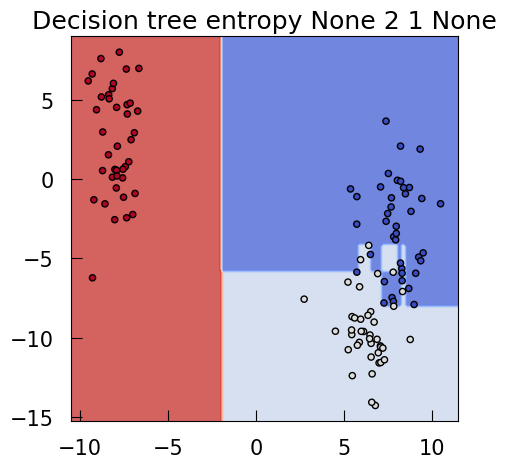

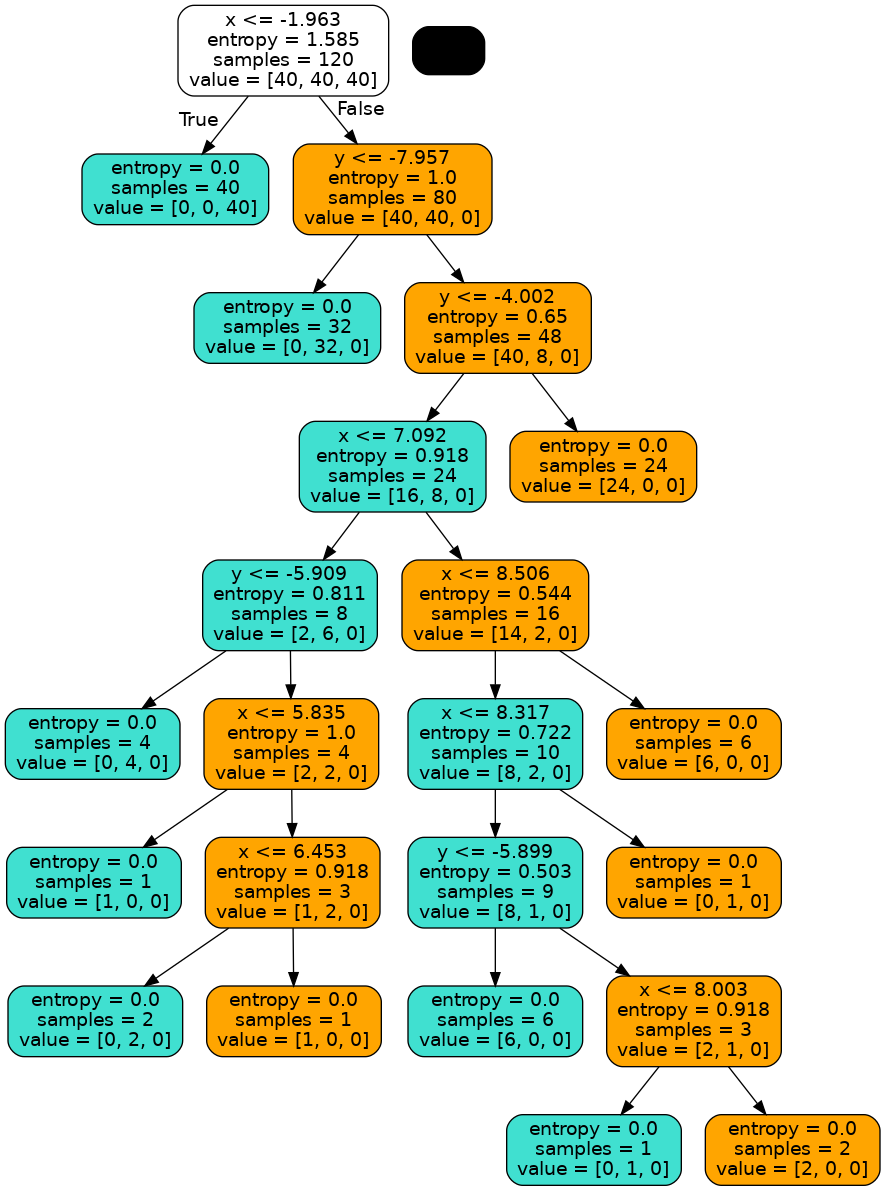

In [59]:
from utils import contour_tree

contour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 2,
              min_l = 1,
              max_f = None)
#You can see that there are 5 hyperparameters here. Let's see what they do and what they mean.
#I bet you can already guess it is going to be related to regularization....
# After X,y you have 
# * crit = 'entropy' which is one way to calculate impurity (you could also put gini here)
# * maxd : the max depth of your tree
# * min_s : the number of points that should be concerned by the making of a new rule (splitting of the nodes)
# * min_l : #of points that should be considered to make a final leaf classification
# * max_f maximum number of features to consider for making a new rule...

Well that's a really complicated and zealous tree. Look at those boundaries. Clearly if we just let it go like that it is overfitting...

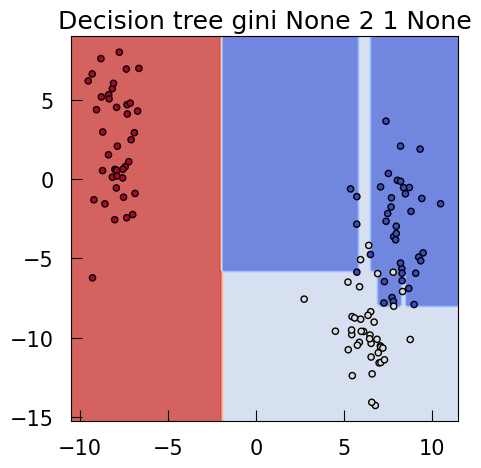

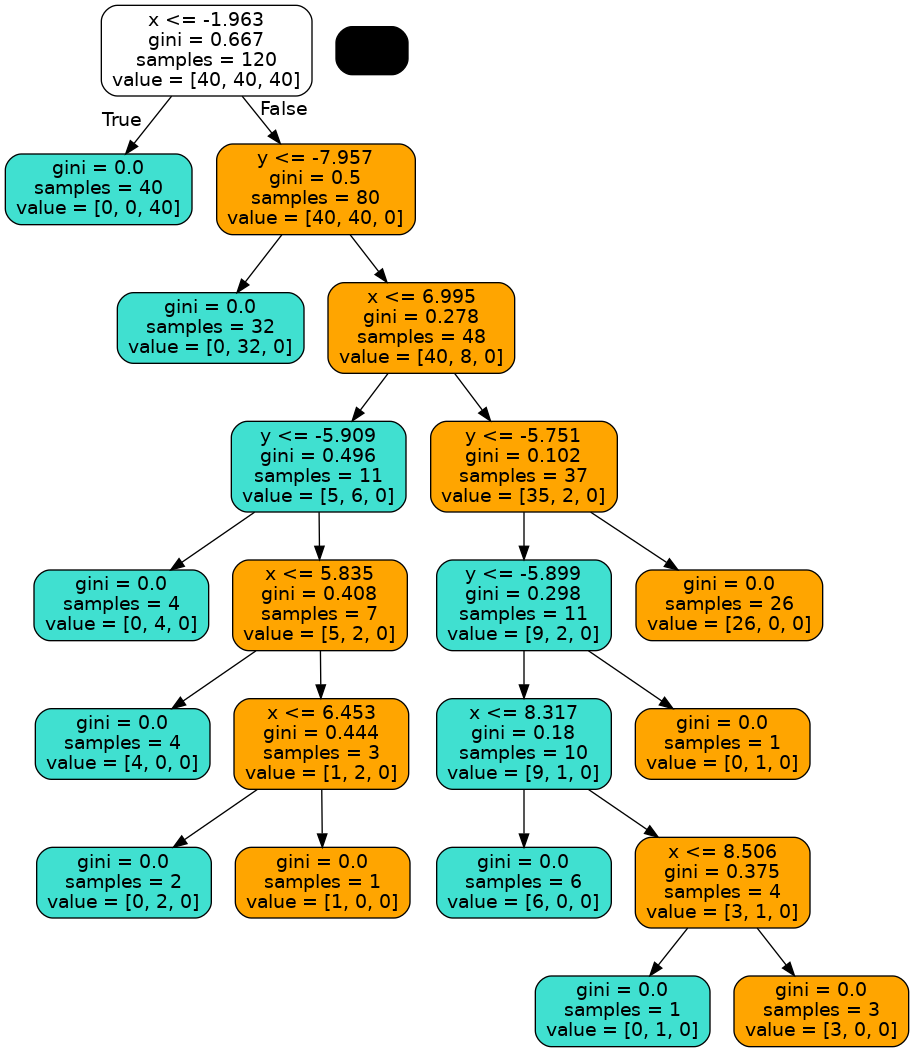

In [60]:
#using another impurity measurement
contour_tree(X_3, y_3,
              crit = 'gini',
              maxd = None,
              min_s = 2,
              min_l = 1,
              max_f = None)

Still some overfitting but it is nice to see that the boundaries are different and that impurity calculations, even if very similar, are making a difference.

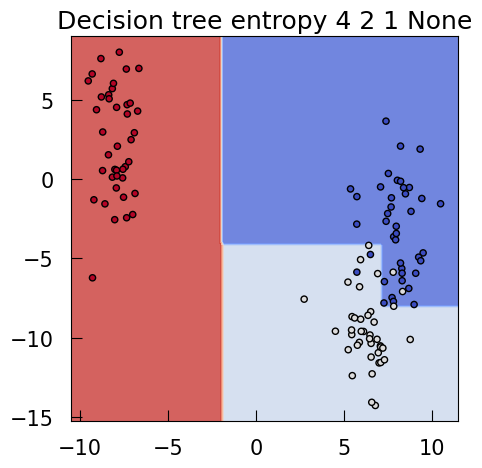

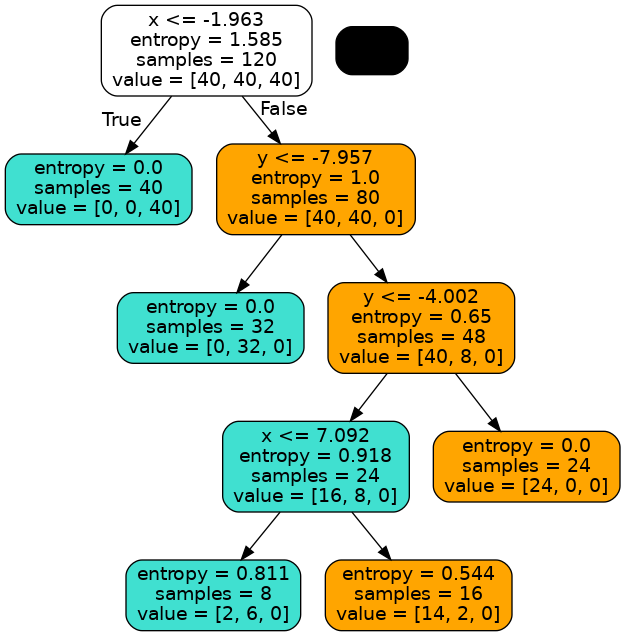

In [61]:
#Imposing a limit for the depth of the tree : how many questions you ask (here set to 4)
contour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = 4,
              min_s = 2, min_l = 1, max_f = None)

Indeed only a maximum of 4 splitting events link the root to the leafs.

Here you stopped the tree at some points allowing some misslabelling instead of fitting perfectly the dataset.

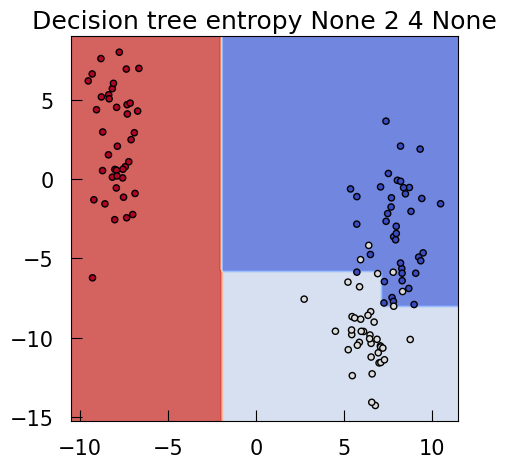

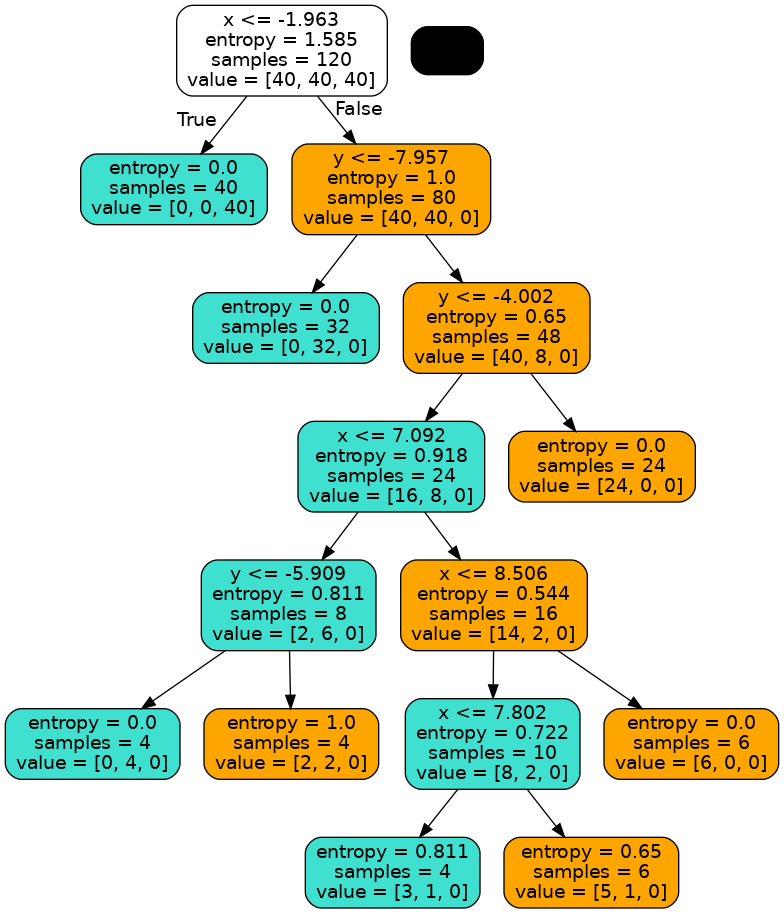

In [62]:
contour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 2,
              min_l = 4,
              max_f = None)
# I don't really have a strong feeling about where I should stop the tree depth. 
# But I have an understanding of this other parameter (here set to 4) 
# called min_samples_leaf : 
#     it sets the minimal number of data points that the chain of rules should concern. 

# eg. Do you really wish to create a whole new set of rules to explain 
# only one particular data point? 

Convince yourself that now, rules are made for leafs of at least 4 points contrary to trees that we built before and for which you could have leaves containing only 2 points

The tree is simplified and the boundaries look more flexible.

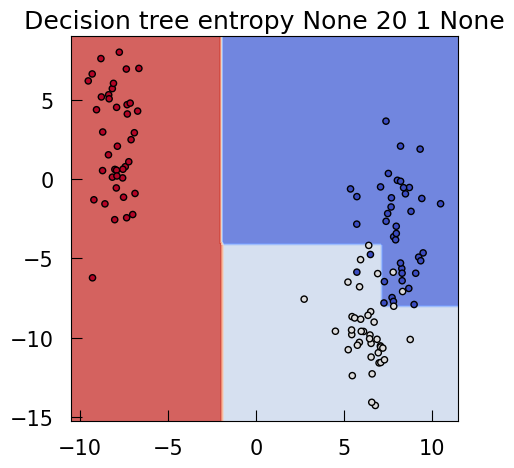

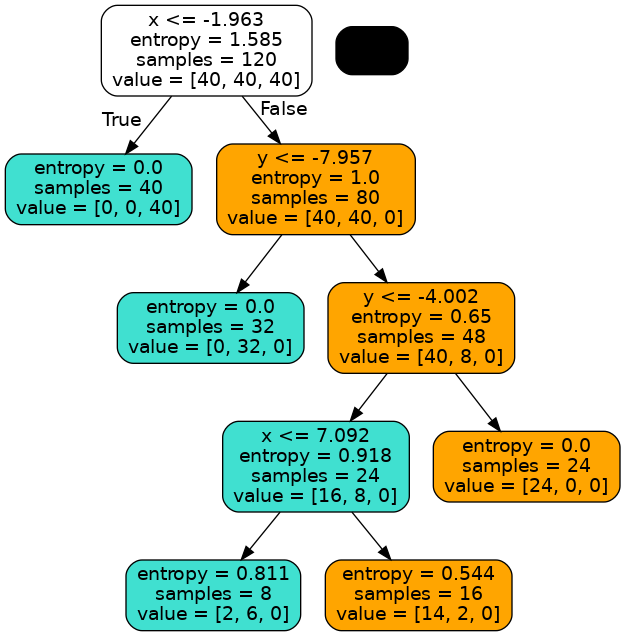

In [63]:
contour_tree(X_3, y_3,
              crit = 'entropy',
              maxd = None,
              min_s = 20,
              min_l = 1,
              max_f = None)
# Here it is the same as before but this time it applies to nodes instead of leaves
# This parameter is called min_samples_split and is set to 20 here.

Check that indeed there is no node splitting concerning less than 20 points

There are 3 main advantages to this kind of methods:
* it works with all types of feature
* you don't need to rescale
* it already includes non linear fitting

**Moreover it is 'easy' to interpret.**

But....(yes there is a but, there is no free lunch)

Even with all of those hyperparamaters **they are still not great on new data (inaccuracy...).** 

We will see that in the real data example below and we will see more powerful technics based on decision tree that are more costly but generalize better.

**micro-exercise :** We didn't check how the maximum number of features (`max_f`) for making a decision would affect the tree. Try it on the toy data.

This hyperparameter set the number of randomly picked features to consider at each node splitting. By setting it up at `None` we consider all the features. But you could also fix that number as you wish or choose a known good scaling for your data which is either square root of the number of features or log2 of the number of features.

> N.B. this only affects node splitting : all the features are considered when the tree is built it is just that you randomly pick from the full set at each node splitting event.

[Back to ToC](#toc)

## Decision tree on the Cancer data set <a id='DTcancer'></a>

Now let's check the effects of those parameters on test and train sets accuracy. Are they acting like regularization?

#### max_depth

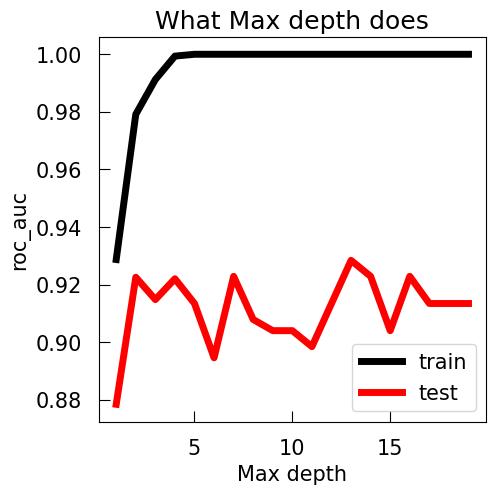

In [64]:
from sklearn.metrics import roc_auc_score
max_dep = range(1,20)
scores_test = []
scores_train = []

for k in max_dep:
    tree = DecisionTreeClassifier(max_depth = k,class_weight='balanced')
    tree.fit(X_cancer_train,y_cancer_train)
    y_train_prob = tree.predict_proba(X_cancer_train)
    y_test_prob = tree.predict_proba(X_cancer_test)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])
        
    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)


# plotting
plt.plot(max_dep, scores_train,'k-',linewidth=5,label='train')
plt.plot(max_dep, scores_test,'r-',linewidth=5,label='test')
plt.xlabel('Max depth')
plt.ylabel('roc_auc')
plt.title('What Max depth does')
plt.legend(loc='best')

#### min_samples_split

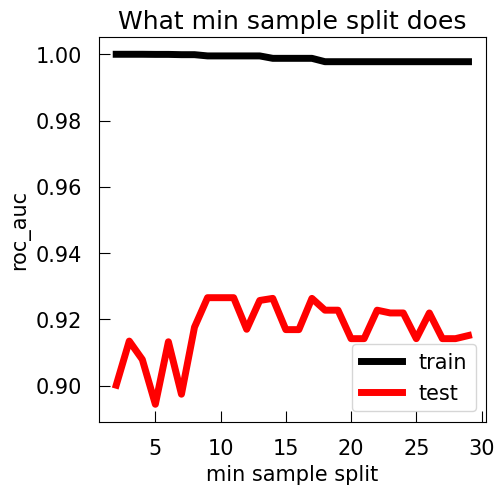

In [65]:
min_samples_spl = range(2,30)
scores_test = []
scores_train = []

for k in min_samples_spl:
    tree = DecisionTreeClassifier(min_samples_split = k,class_weight='balanced')
    tree.fit(X_cancer_train,y_cancer_train)
    y_train_prob = tree.predict_proba(X_cancer_train)
    y_test_prob = tree.predict_proba(X_cancer_test)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])
        
    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)


plt.plot(min_samples_spl, scores_train,'k-',linewidth=5,label='train')
plt.plot(min_samples_spl, scores_test,'r-',linewidth=5,label='test')
plt.xlabel('min sample split')
plt.ylabel('roc_auc')
plt.title('What min sample split does')
plt.legend(loc='best')

`min_sample_split` in our case doesn't seem to do much. But overall it seems a value between 5 and 15 performs best on the test set.

#### min_samples_leaf

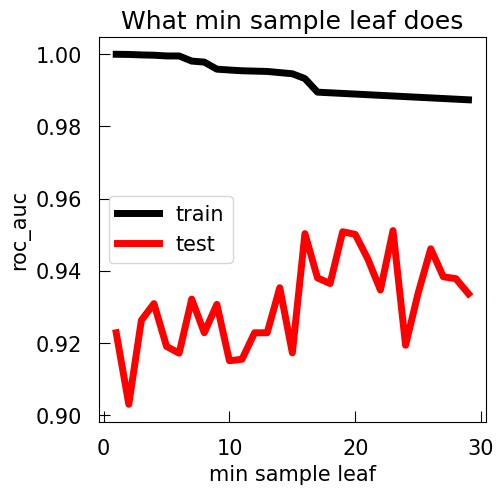

In [66]:
min_samples_lea = range(1,30)
scores_test = []
scores_train = []

for k in min_samples_lea:
    tree = DecisionTreeClassifier(min_samples_leaf = k,class_weight='balanced')
    tree.fit(X_cancer_train,y_cancer_train)
    y_train_prob = tree.predict_proba(X_cancer_train)
    y_test_prob = tree.predict_proba(X_cancer_test)

    train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
    test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])
        
    scores_test.append(test_roc_auc_score)
    scores_train.append(train_roc_auc_score)


plt.plot(min_samples_lea, scores_train,'k-',linewidth=5,label='train')
plt.plot(min_samples_lea, scores_test,'r-',linewidth=5,label='test')
plt.xlabel('min sample leaf')
plt.ylabel('roc_auc')
plt.title('What min sample leaf does')
plt.legend(loc='best')
plt.show()

How do you interpret this plot?

#### Let's train our model properly

In [67]:
%%time
# define the hyperparameters you want to test
#with the range over which you want it to be tested.
grid_values = {'criterion': ['entropy','gini'],
               'max_depth':np.arange(2,len(X_cancer_train)//2,20),
               'min_samples_split':np.arange(2,len(X_cancer_train)//4,5),
              'min_samples_leaf':np.arange(1,len(X_cancer_train)//20,2)}

grid_tree_roc_auc = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), 
                             param_grid = grid_values, 
                             cv=5,
                             scoring='roc_auc',n_jobs=-1)

grid_tree_roc_auc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_roc_auc=grid_tree_roc_auc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. roc_auc): ', grid_tree_roc_auc.best_params_)
print('Grid best score (roc_auc): ', grid_tree_roc_auc.best_score_)
print('Grid best parameter (max. roc_auc) model on test: ', y_decision_fn_scores_roc_auc)

Grid best parameter (max. roc_auc):  {'criterion': 'entropy', 'max_depth': 142, 'min_samples_leaf': 15, 'min_samples_split': 22}
Grid best score (roc_auc):  0.9790558570591286
Grid best parameter (max. roc_auc) model on test:  0.9255765199161425
CPU times: user 9.39 s, sys: 383 ms, total: 9.77 s
Wall time: 31 s


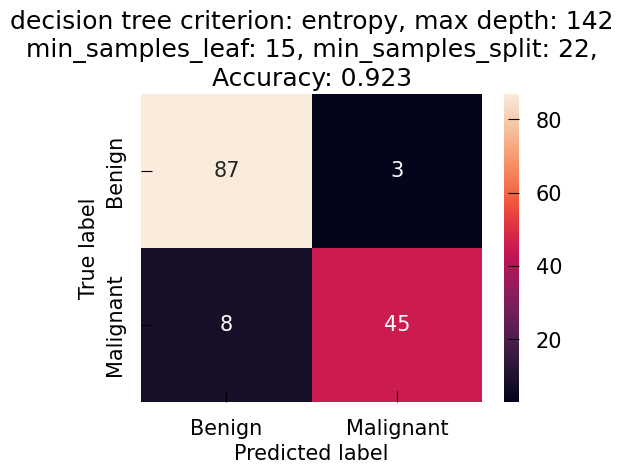

In [68]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred_test_c=grid_tree_roc_auc.predict(X_cancer_test)

# let's define a nice function to get a confusion matrix plot
def plotConfusionMatrix( true_labels, predicted_labels, label_list , title , ax = None):

    confusion_mc_c = confusion_matrix(true_labels, predicted_labels)
    df_cm_c = pd.DataFrame( confusion_mc_c , 
                           index = label_list,
                           columns=label_list)

    if ax is None:
        fig,ax = plt.subplots(figsize=(5.5,4))
    sns.heatmap(df_cm_c, annot=True , ax = ax)
    ax.set_title(title)
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')


    
## predicting the labels on the test set    
y_pred_test_c=grid_tree_roc_auc.predict(X_cancer_test)

bestCrit = grid_tree_roc_auc.best_params_["criterion"]
bestMD = grid_tree_roc_auc.best_params_["max_depth"]
bestMSL = grid_tree_roc_auc.best_params_["min_samples_leaf"]
bestMSS = grid_tree_roc_auc.best_params_["min_samples_split"]


plotTitle = """decision tree criterion: {}, max depth: {}
min_samples_leaf: {}, min_samples_split: {},
Accuracy: {:.3f}""".format(bestCrit,bestMD,bestMSL,bestMSS,
                           accuracy_score(y_cancer_test,y_pred_test_c) )


plotConfusionMatrix( y_cancer_test, y_pred_test_c, 
                    ['Benign','Malignant'] , plotTitle , 
                    ax = None)


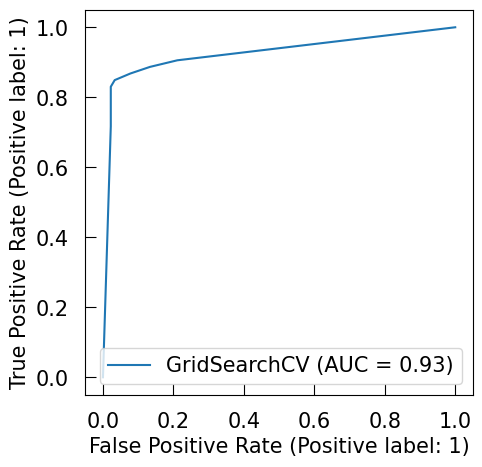

In [69]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(grid_tree_roc_auc,X_cancer_test, y_cancer_test)

That's a very complicated tree..... And not performing as well as you would expect from something so complicated....

#### feature importance

Feature importance in tree is calculated by checking the amount of impurity reduction link to a feature. We will use it but there are some problems in using that definition of feature importance (the main one being caridnality : if your features have a lot of possible value it becomes easier to find a good impurity splitting compared to a binary feature). A more robust way to do it would be to use permutation importance, which relies on looking at the effect of scrambling the values of a feature and see how much it impacts the model. Try it at some point, even on non tree algorithm [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance). 


In [70]:

tree = grid_tree_roc_auc.best_estimator_

w=tree.feature_importances_#get the weights


featureW = pd.DataFrame( {'feature': df_cancer.columns[:-1],
                        'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]


Features sorted per importance:


,feature,weight
22,worst perimeter,0.743701
27,worst concave points,0.116318
20,worst radius,0.059365
7,mean concave points,0.046750
14,smoothness error,0.019509
28,worst symmetry,0.014357


[Back to the ToC](#toc)

##  Exercise : Decision tree <a id="DTexo"></a>

Train the best decision tree possible for classifying penguin species

In [92]:
# %load -r -19 solutions/solution_03_DT.py

In [91]:
# %load -r 19- solutions/solution_03_DT.py

[Back to ToC](#toc)

# Random Forest <a class="anchor" id="Random-Forest"></a>

the Random Forest algorithm relies on two main concepts : 
1. **randomly producing/training many different trees**
2. **agglomerating the predictions** of all these trees (mainly averaging)


The randomness between trees concerns:
* **[bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)) of the training dataset**
* using only a **random subset of features**


**Bootstrapping:** sampling methods in which you randomly draw a subsample from your data, *with replacement*. The created replicate is the same size as the original distribution.

I am sure you can see intuitively how that is going to help generalization of our model.

So now on top of all the parameters seen before to create each individual trees of the forest, you also have a parameter controlling the number of trees in your forest.


> In the following plots we will compare the results of a random forest with a single decision tree with the same hyperparameter values


![RF](../images/RF.png)

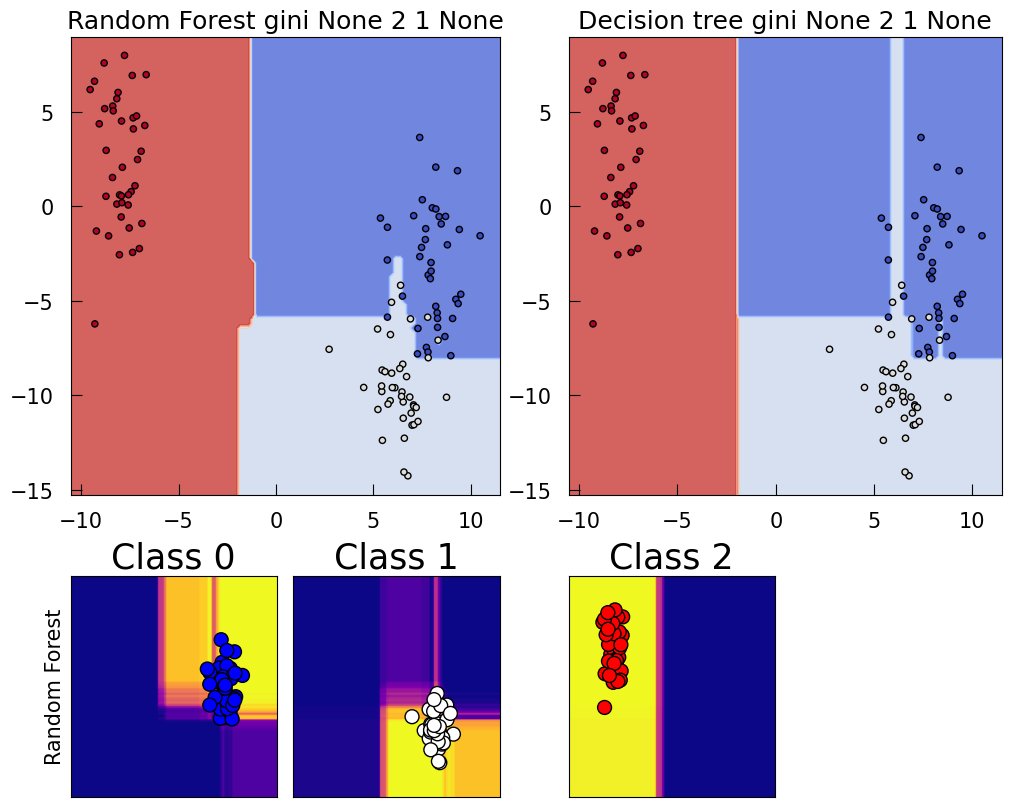

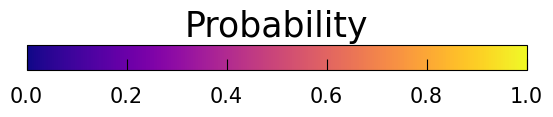

In [73]:
from utils import contour_RF
contour_RF(X_3, y_3,
            n_tree = 100,
            crit = 'gini',
            maxd = None,
            min_s = 2,
            min_l = 1,
            max_f = None)
#Same as for decision tree except that we have here one more hyperparameter, 
# here put to 100 and that represents the number of bootstraps 
# (number of trees trained and then participating to the vote)

See how in the case of random forest the iso-probability lines are less binary than in the case of the decision tree? 

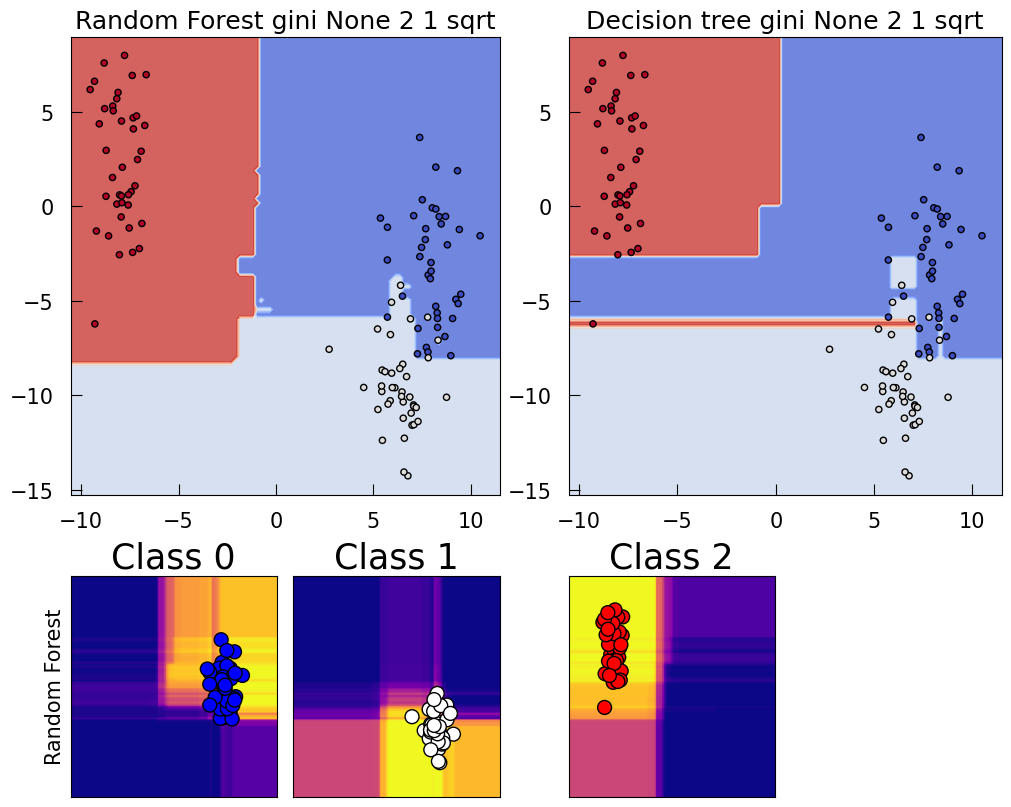

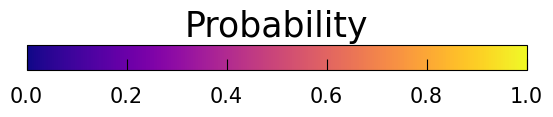

In [74]:
contour_RF(X_3, y_3,
            n_tree = 100, crit = 'gini',maxd = None, min_s = 2, min_l = 1,
            max_f = 'sqrt')
# The difference here is that we set the max number of feature to split node to sqrt 
# (square root of the total number of features). 
#Before with None we were considering all the feature for node splitting.

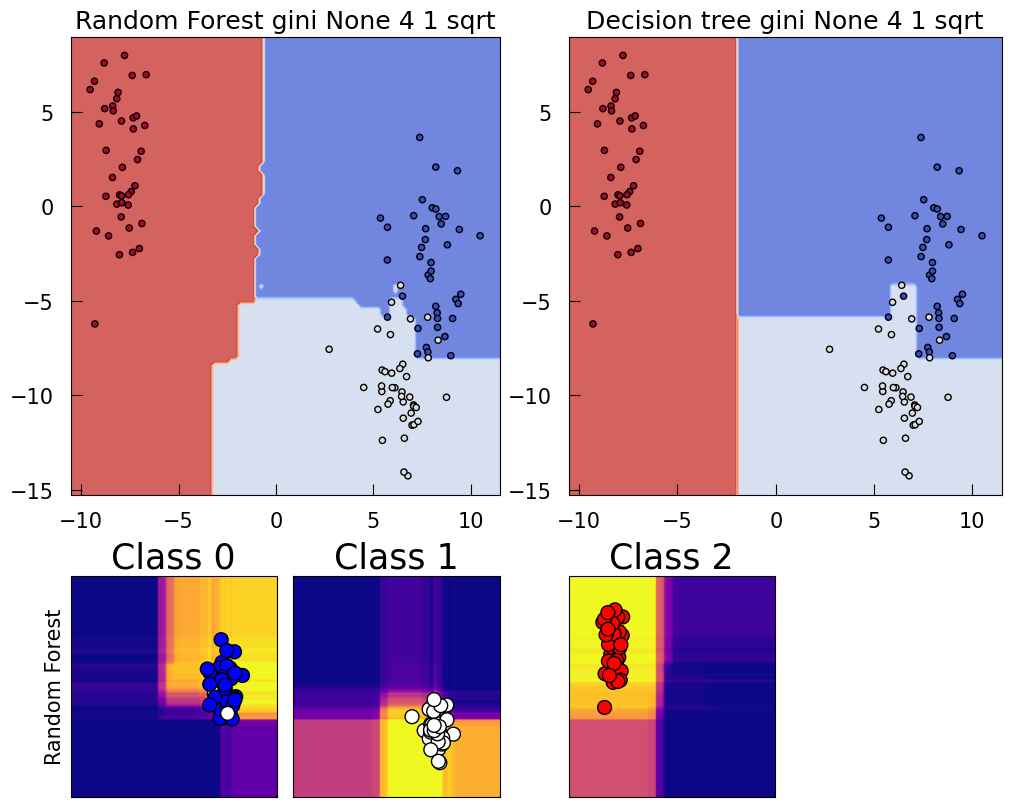

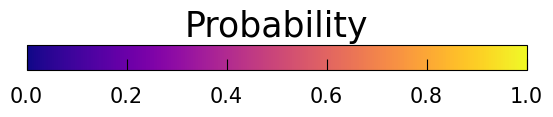

In [75]:
contour_RF(X_3, y_3,
            n_tree = 100, crit = 'gini', maxd = None,
            min_s = 4,
            min_l = 1, max_f = 'sqrt')
# We change min sample split from 2 to 4, 
# that would be equivalent to add some regularization.

We added a little bit of regularization in the single tree and so we can start to see less sharp borders. For the random forest it changes a bit the contours.

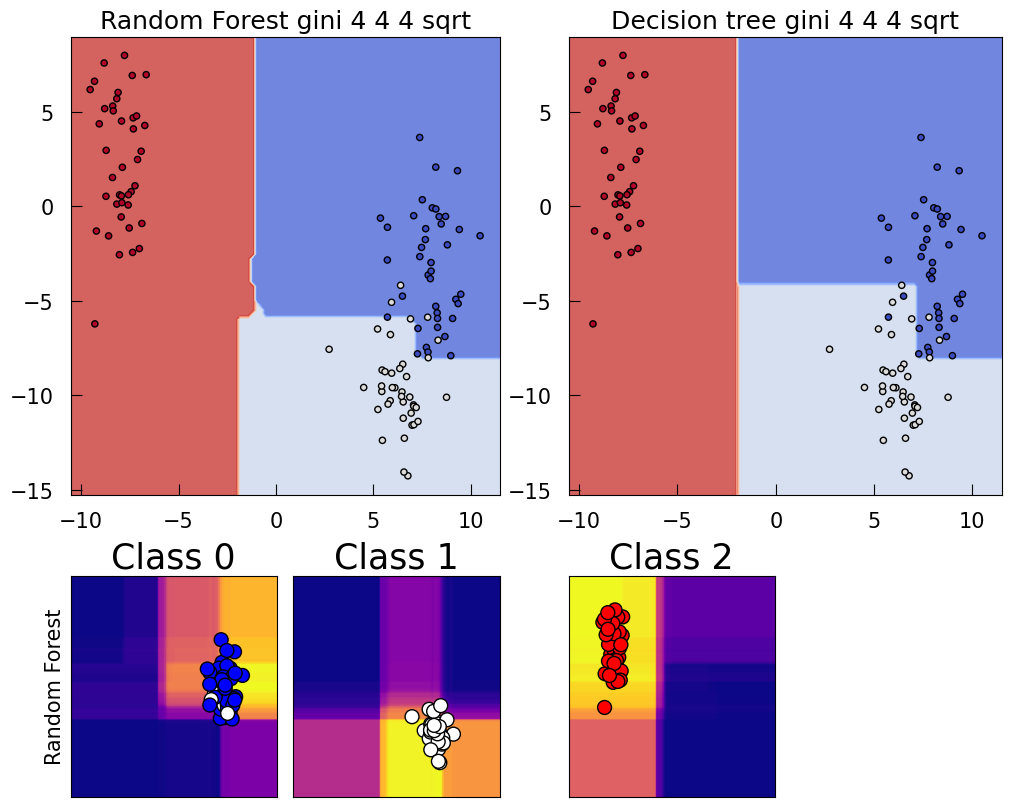

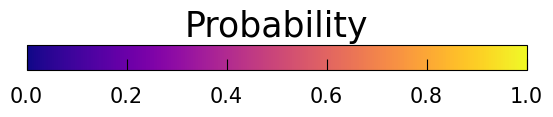

In [76]:
contour_RF(X_3, y_3,
            n_tree = 100, crit = 'gini',
            maxd = 4, 
            min_s = 4,
            min_l = 4,
            max_f = 'sqrt')
#Even more regularization, now we are more stringent on the size of the leaf and the 
#max depth of the individual trees

[BAck to the ToC](#toc)

## Random forest on the Penguin data set <a id="RFpenguin"></a>

Here 50 trees is probably a good guess.

In [97]:
%%time
from sklearn.metrics import confusion_matrix,accuracy_score

## I base some of these values on what we found with a single tree
## it stands to reason that the tree in the forest would be somewhat similar or simpler to the best tree we found earlier
grid_values = {'criterion': ['entropy','gini'],
               'n_estimators':np.arange(25,101,25), 
               'max_depth':[1,2,3],
               'min_samples_split':[40,45,50],
              'min_samples_leaf':[8,10,12]}

grid_rf_roc_auc = GridSearchCV(RandomForestClassifier(n_jobs=-1,class_weight='balanced'), 
                             param_grid = grid_values, 
                             scoring='roc_auc_ovr_weighted',n_jobs=-1)

grid_rf_roc_auc.fit(X_penguin_train, y_penguin_train)

y_decision_fn_scores_roc_auc=grid_rf_roc_auc.score(X_penguin_test, y_penguin_test)

print('Grid best parameter (max. roc_auc_ovr_weighted): ', grid_rf_roc_auc.best_params_)
print('Grid best score (roc_auc_ovr_weighted): ', grid_rf_roc_auc.best_score_)
print('Grid best parameter (max. roc_auc_ovr_weighted) model on test: ', y_decision_fn_scores_roc_auc)

Grid best parameter (max. roc_auc_ovr_weighted):  {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 40, 'n_estimators': 25}
Grid best score (roc_auc_ovr_weighted):  0.9994494765753268
Grid best parameter (max. roc_auc_ovr_weighted) model on test:  1.0
CPU times: user 1.65 s, sys: 72.2 ms, total: 1.72 s
Wall time: 39.6 s


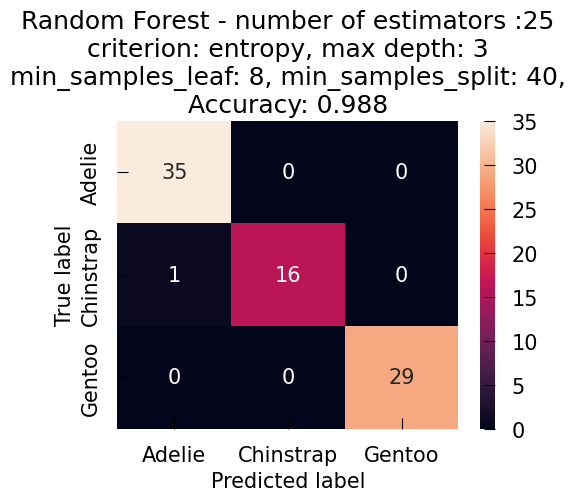

In [99]:
## predicting the labels on the test set    
y_pred_test=grid_rf_roc_auc.predict(X_penguin_test)

bestN = grid_rf_roc_auc.best_params_["n_estimators"]
bestCrit = grid_rf_roc_auc.best_params_["criterion"]
bestMD = grid_rf_roc_auc.best_params_["max_depth"]
bestMSL = grid_rf_roc_auc.best_params_["min_samples_leaf"]
bestMSS = grid_rf_roc_auc.best_params_["min_samples_split"]


plotTitle = """Random Forest - number of estimators :{}
criterion: {}, max depth: {}
min_samples_leaf: {}, min_samples_split: {},
Accuracy: {:.3f}""".format(bestN,bestCrit,bestMD,bestMSL,bestMSS,
                           accuracy_score(y_penguin_test,y_pred_test) )


plotConfusionMatrix( y_penguin_test, y_pred_test, 
                    ['Adelie','Chinstrap','Gentoo'] , plotTitle , 
                    ax = None)


In [101]:
RF = grid_rf_roc_auc.best_estimator_

w=RF.feature_importances_#get the weights

featureW = pd.DataFrame( {'feature': X_penguin.columns,'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]

Features sorted per importance:


,feature,weight
2,Flipper Length (mm),0.268959
5,Delta 13 C (o/oo),0.239070
1,Culmen Depth (mm),0.154092
0,Culmen Length (mm),0.134226
6,Island_Dream,0.087570
3,Body Mass (g),0.065692
4,Delta 15 N (o/oo),0.045024
7,Island_Torgersen,0.004069
8,Clutch Completion_Yes,0.001297


[Back to ToC](#toc)

# ADA Boost <a class="anchor" id="Ada-Boost"></a>

As in Random Forest, you have a forest of trees, or rather, of *stumps*. However:

* ADA boost considers **only the simplest type of trees : a single node with a yes or no question on one feature.** 
* Also, **in ADA boost stumps have different contributions in the final decision.** 
* Stumps are linked and there is an **order and a logical reason that links two contiguous stumps.**



Each stump is made by **taking the previous stumps mistakes into account** and try to remedy them.
How? By applying an importance weight on each sample : **missclassified points are given a higher weight** so that the next stumps are encouraged to focus on them.


**Stumps have more to say in the classification if they have been better at classifying in general!** 

![ADA](../images/ADA.png)

The voting weight for the stump $h_{t}$ is of the form $\alpha_{t}=L*log(\frac{1 - total.weigthed.error_{t}}{total.weigthed.error_{t}})$, where $L$ is the **learning rate**.

> NB : If a specific stump misclassifies 100% of the data it is actually a really good classifier if you decide to just reverse the labels...


The **learning rate** represents how much does the new iteration can deviate from the previous one. This is our new hyperparameter.


The update of the importance of individual points is following the the same formula as voting and then put in an exponential to get the updated weights:

$w^{t+1}_{i}=w^{t}_{i}e^{\alpha_{t+1}}$ if $h_{t+1}$ made a mistake for point $i$

> Those weights are then normalized.

And at the end classification is made following a weighted average of the stumps:

$G(x)=\sum^{T}_{t=1}\alpha_{t}G_{t}(x)$


### Hyperparameters

Since we are only using stumps we get rid of all the other hyperparameters describing the tree topology (max depth, min samples split, min leaf split ).

The only one left are the number of stumps (`n_estimators`) and the learning rate (`learning_rate`).

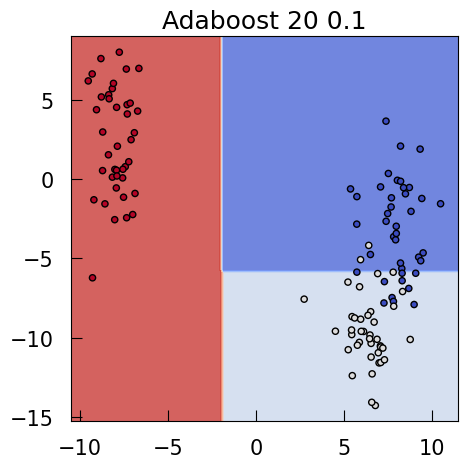

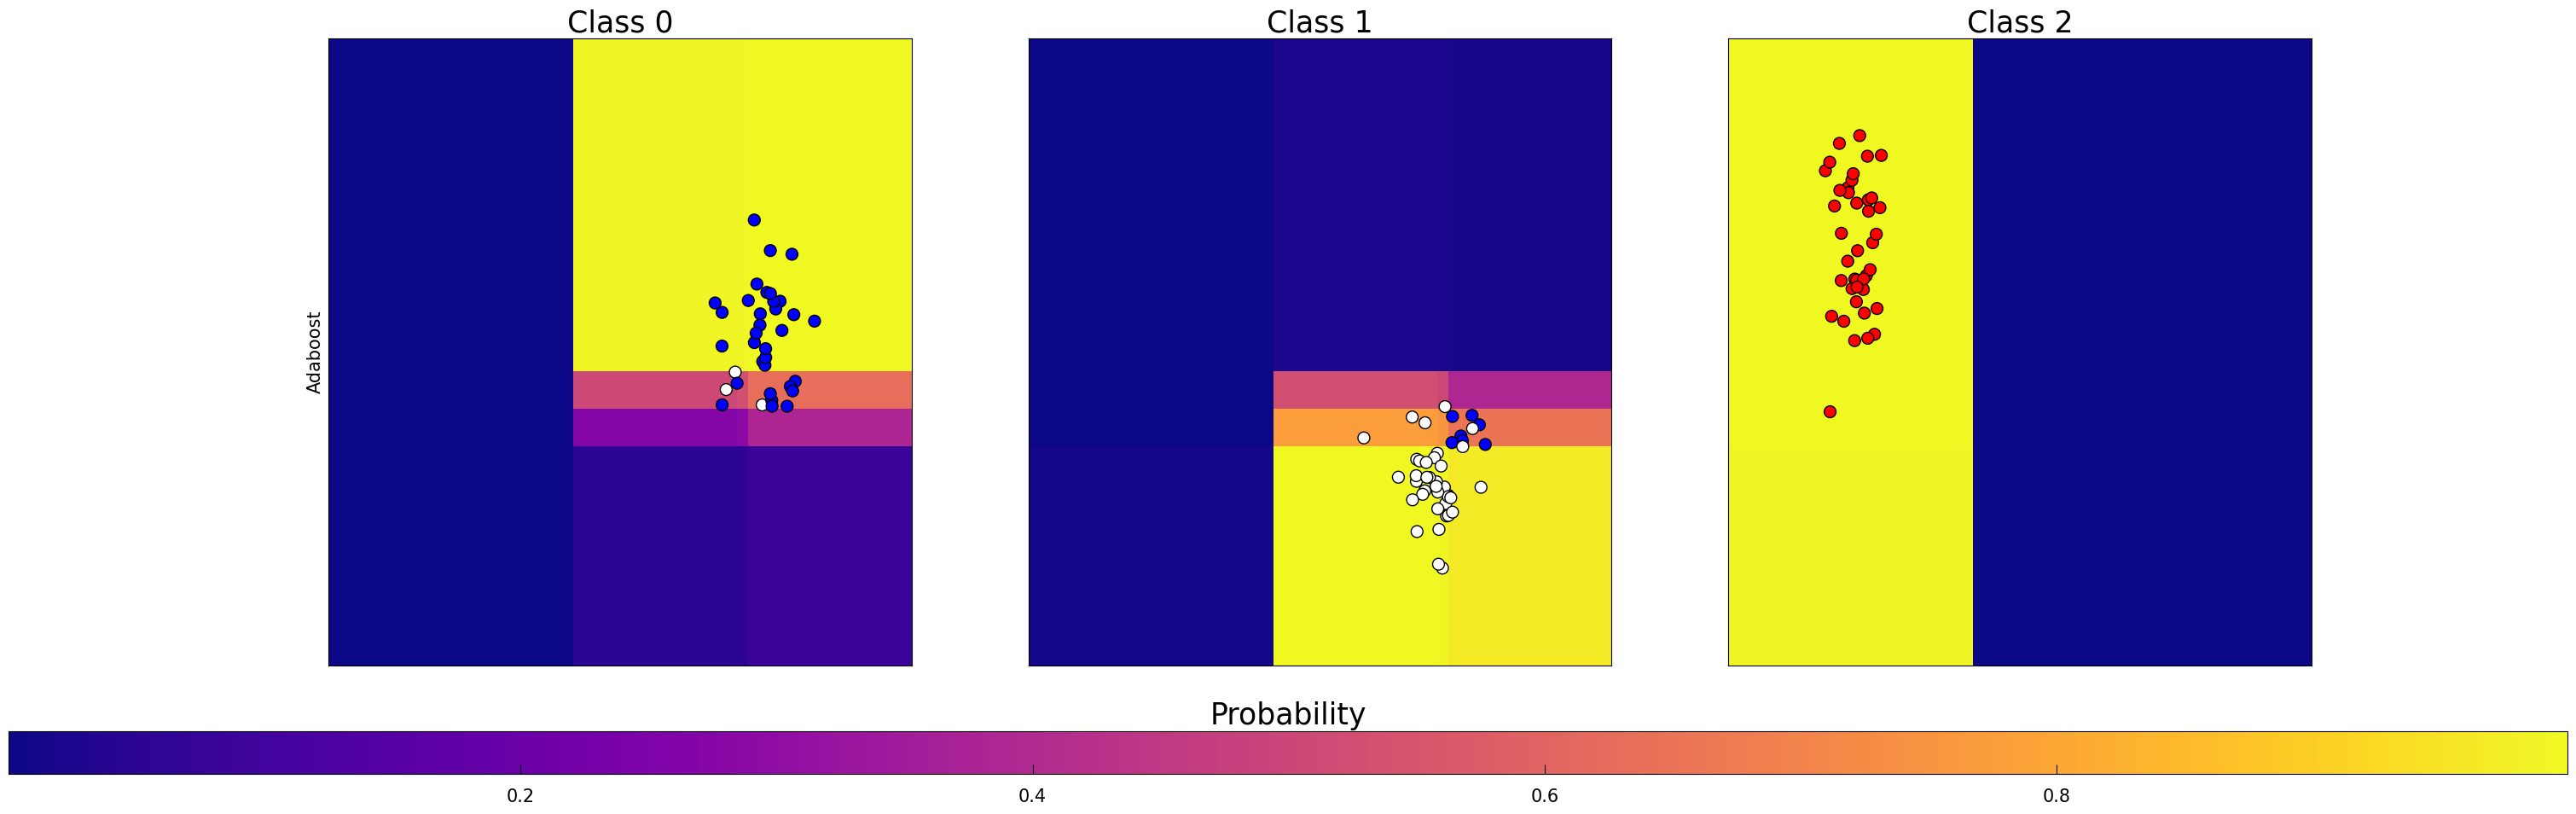

In [102]:
from utils import contour_ADA
contour_ADA(X_3, y_3,
             n_estimators = 20 ,
             learning_rate = 0.1) #20 stumps, learning rate is 0.1

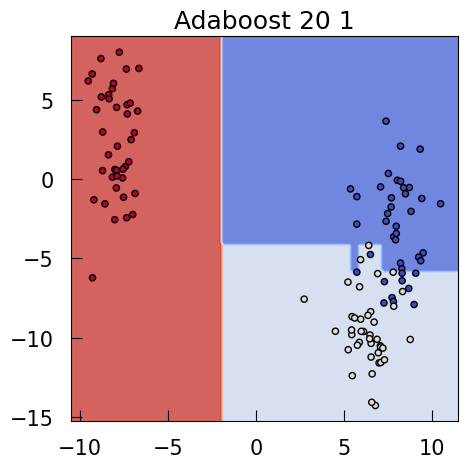

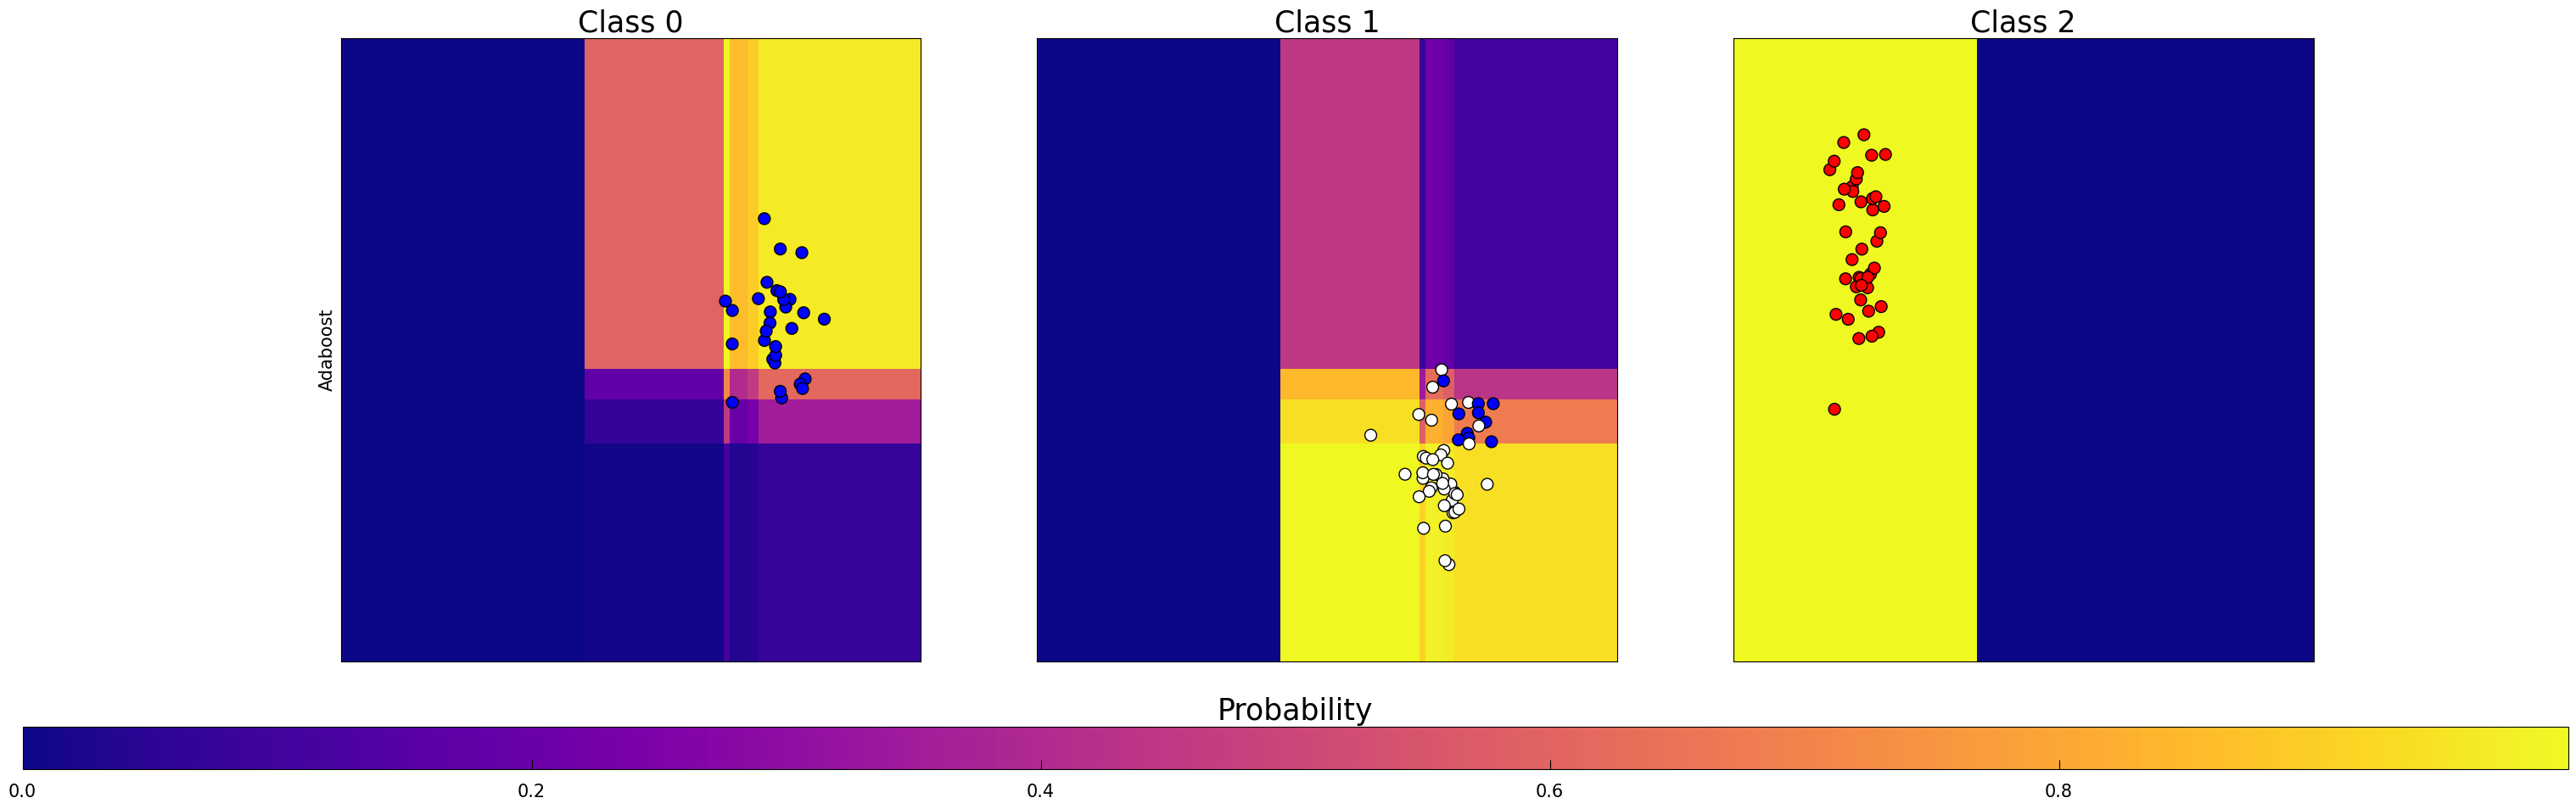

In [103]:
contour_ADA(X_3, y_3, n_estimators = 20 , learning_rate= 1) #learning rate is 1

### Cancer dataset

CPU times: user 31.8 s, sys: 0 ns, total: 31.8 s
Wall time: 31.8 s


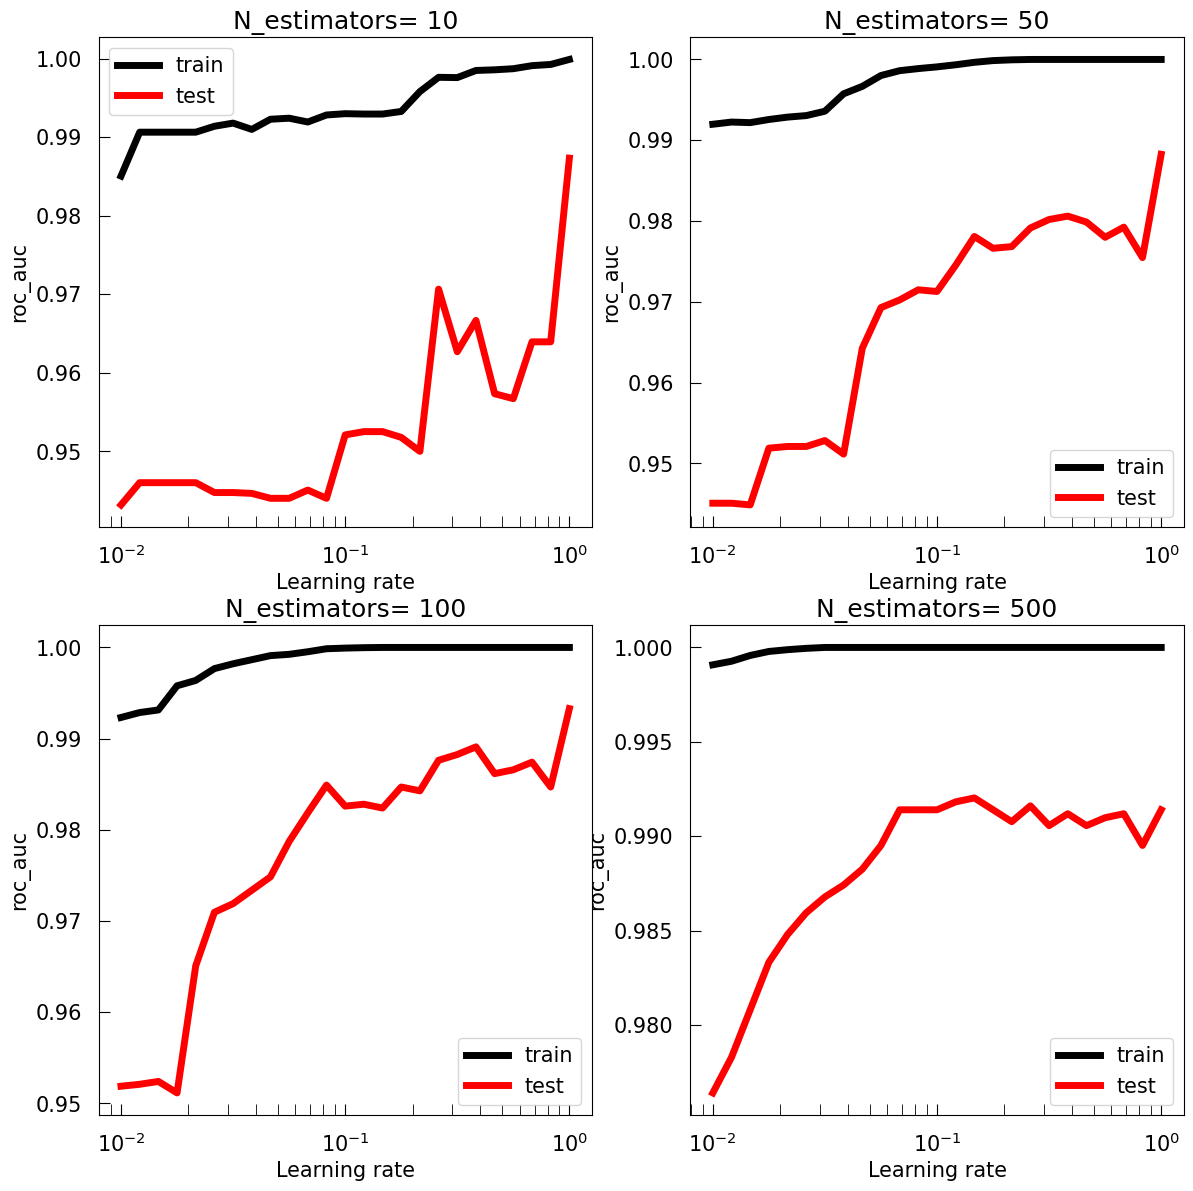

In [104]:
%%time
l_rate=np.logspace(-2,0,25) 

fig,axes = plt.subplots(2,2,figsize=(14,14))

n_estimator=[10,50,100,500]
for i,ne in enumerate( n_estimator ):
    scores_test = []
    scores_train = []
    for k in l_rate:
        tree = AdaBoostClassifier(n_estimators=ne,learning_rate=k)
        tree.fit(X_cancer_train,y_cancer_train)
        y_train_prob = tree.predict_proba(X_cancer_train)
        y_test_prob = tree.predict_proba(X_cancer_test)

        train_roc_auc_score=roc_auc_score(y_cancer_train,y_train_prob[:, 1])
        test_roc_auc_score=roc_auc_score(y_cancer_test,y_test_prob[:, 1])
        
        scores_test.append(test_roc_auc_score)
        scores_train.append(train_roc_auc_score)

    ax = axes[i//2][i%2]
    ax.set_xlabel('Learning rate')
    ax.set_ylabel('roc_auc')
    ax.set_xscale('log')
    ax.set_title('N_estimators= '+str(ne))
    ax.plot(l_rate, scores_train,'k-',linewidth=5,label='train')
    ax.plot(l_rate, scores_test,'r-',linewidth=5,label='test')
    ax.legend(loc='best')


The two hyperparameters number of of stumps and learning rate are actually interdependent. The law associating the two is not obvious but just keep in mind that if the number of stumps is large you don't need a big learning rate.

In [113]:
%%time
grid_values = {'n_estimators':np.arange(500,1500,250), 
               'learning_rate':np.logspace(-1,1,5) 
               }

grid_ADA_roc_auc = GridSearchCV(AdaBoostClassifier(), 
                             param_grid = grid_values, 
                             scoring='accuracy',
                             n_jobs=-1)

grid_ADA_roc_auc.fit(X_cancer_train, y_cancer_train)

y_decision_fn_scores_roc_auc=grid_ADA_roc_auc.score(X_cancer_test,y_cancer_test)

print('Grid best parameter (max. roc_auc): ', grid_ADA_roc_auc.best_params_)
print('Grid best score (roc_auc): ', grid_ADA_roc_auc.best_score_)
print('Grid best parameter (max. roc_auc) model on test: ', y_decision_fn_scores_roc_auc)

Grid best parameter (max. roc_auc):  {'learning_rate': 1.0, 'n_estimators': 750}
Grid best score (roc_auc):  0.9741723666210671
Grid best parameter (max. roc_auc) model on test:  0.9440559440559441
CPU times: user 1.52 s, sys: 89.6 ms, total: 1.61 s
Wall time: 51.9 s


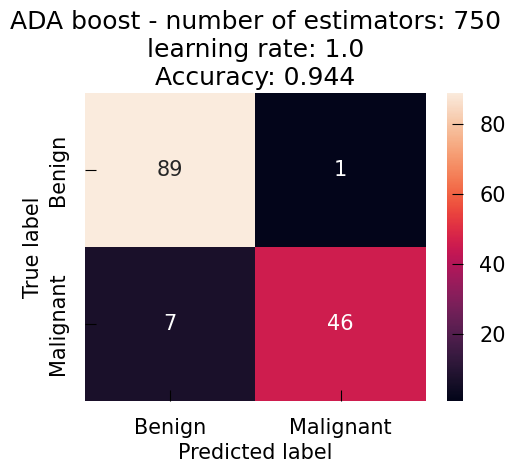

In [114]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred_test_c=grid_ADA_roc_auc.predict(X_cancer_test)

    
bestNE = grid_ADA_roc_auc.best_params_["n_estimators"]
bestLR = grid_ADA_roc_auc.best_params_["learning_rate"]

plotTitle = """ADA boost - number of estimators: {}
learning rate: {}
Accuracy: {:.3f}""".format(bestNE,bestLR,
                           accuracy_score(y_cancer_test,y_pred_test_c) )


plotConfusionMatrix( y_cancer_test, y_pred_test_c, 
                    ['Benign','Malignant'] , plotTitle , 
                    ax = None)


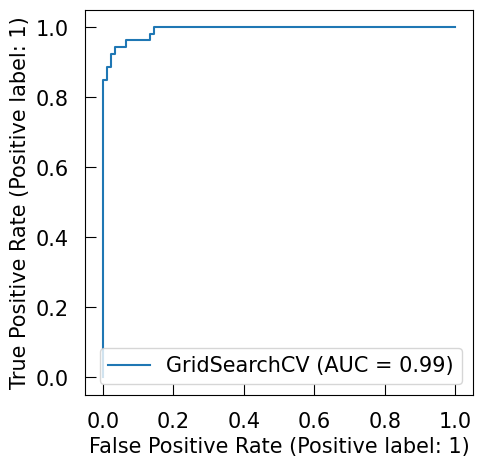

In [115]:
RocCurveDisplay.from_estimator(grid_ADA_roc_auc,X_cancer_test, y_cancer_test)

[Back to ToC](#toc)

# Boosted gradient <a class="anchor" id="Boosted-Gradient"></a>

As you can already imagine from the name, in boosted gradient the 
optimization algorithm follows the gradient of a loss function (or a likelihood function!).

Just like ADAboost and random forest, boosted gradient **creates many trees and datasets**. 

In oposition to ADAboost each tree (not limited to stumps this time) is **fitted on the error from the previous tree** rather than a re-weighted dataset.

In the end you have a quorum of trees for which the **voting is done proportionally to the gradient value.**

![boosted](../images/boosted.png)


Boosted **gradient** refers to the gradient of a **loss function**.

When performing classification, the algorithm transforms the leaves scores into **log-odds ratio**, thus internally **switching from a classification problem to a regression one**.

This new perspective enables highly non linear classification rules, based on logistic regression.


Then, from tree to tree (ie. iterations), the algorithm tries to minimize the difference between the predicted log odds and its labeled values (1 or 0).

> This method is naturally adapted to regression as well, given that when we do a classification we actually have to transform into a regression problem.

#### hyperparameters

* single tree hyperparameters : 
    - Max Tree depth : `max_depth`
    - Min Splitting of nodes : `min_samples_split`
    - Min Splitting of leaves : `min_samples_leaf`
    - Max number of features : `max_features`
* number of iterations : `n_estimators`
* learning rate `learning_rate`


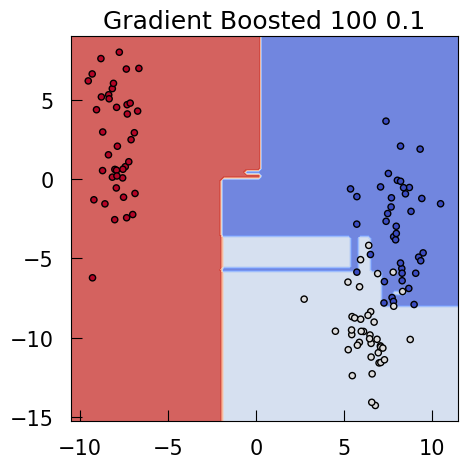

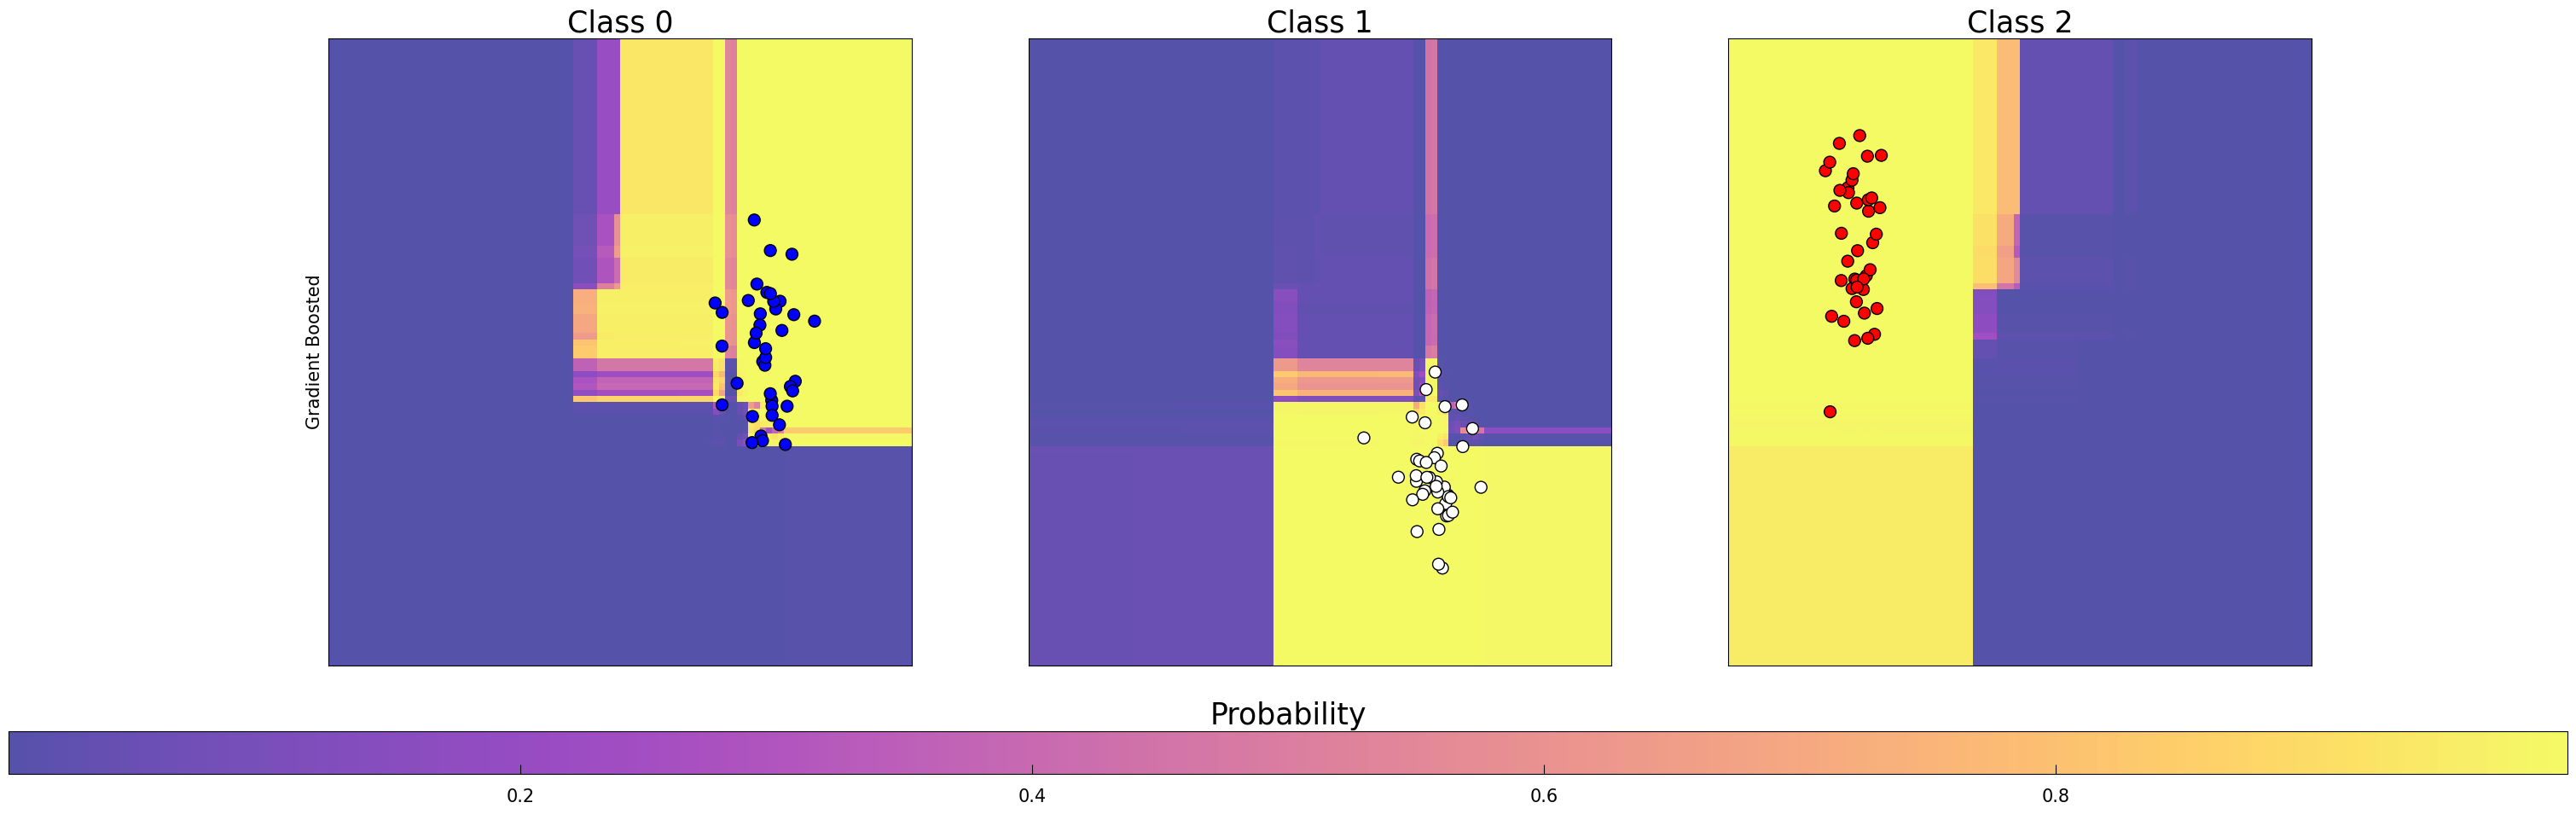

In [116]:
from utils import contour_BG
contour_BG(X_3,y_3,
            n_estimators=100,
            learning_rate=0.1,
            max_depth=4,min_samples_split=2,min_samples_leaf=2,max_features='sqrt')

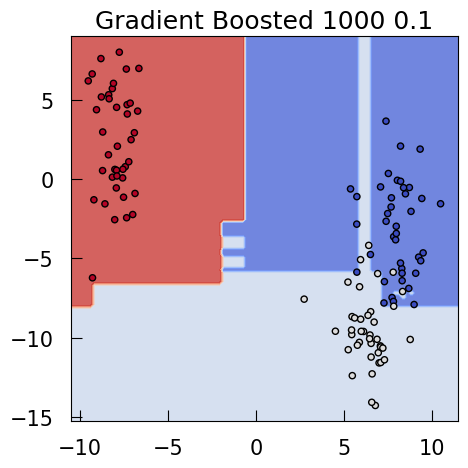

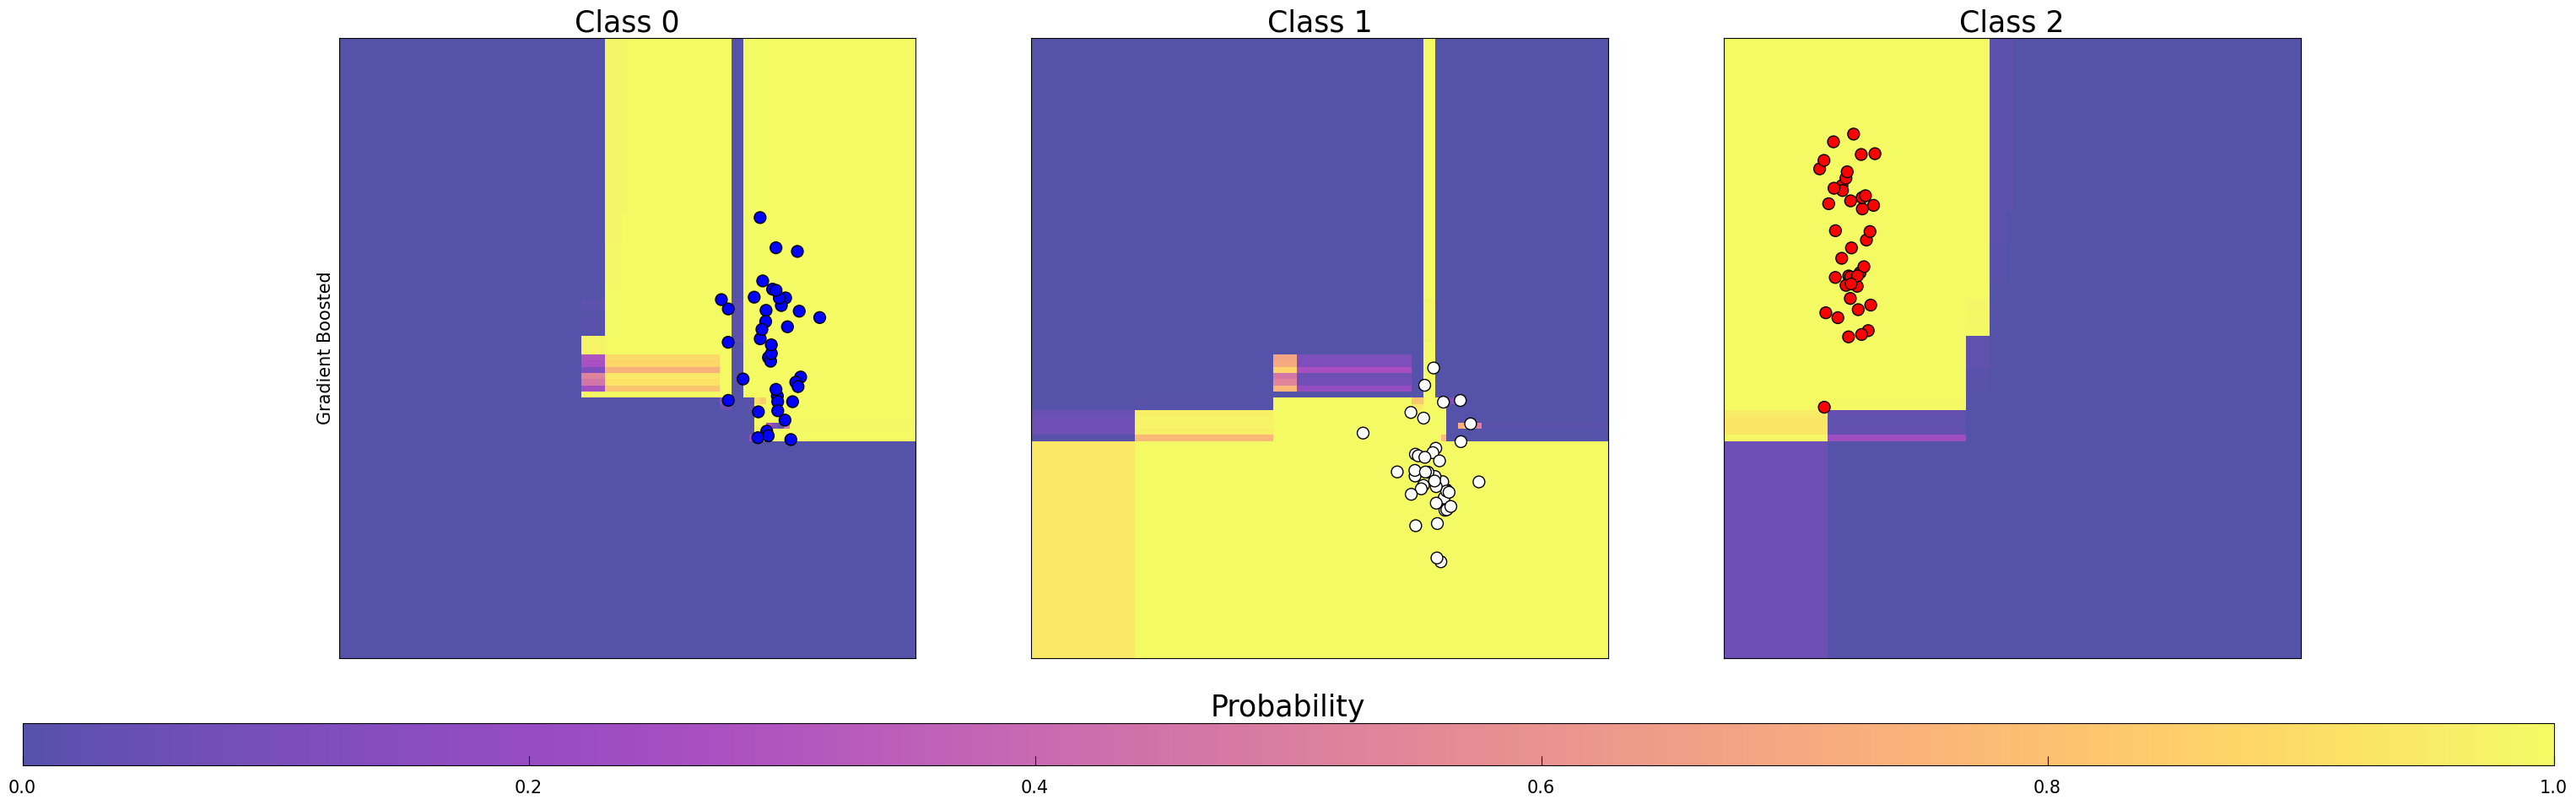

In [117]:
## more iterations
contour_BG(X_3,y_3,
            n_estimators=1000,
            learning_rate=0.1,
            max_depth=4,min_samples_split=2,min_samples_leaf=2,max_features='sqrt')

## Boosted gradient on the penguin dataset

In [122]:
%%time
grid_values = {'learning_rate':np.logspace(-1,1,5),
                'n_estimators':np.arange(100,501,100), 
               'max_depth':[2,3],
               'min_samples_split':[20],
              'min_samples_leaf':[10]}

grid_boosted_roc_auc = GridSearchCV(GradientBoostingClassifier(), 
                             param_grid = grid_values, 
                             scoring='roc_auc_ovr_weighted',n_jobs=-1)

grid_boosted_roc_auc.fit(X_penguin_train, y_penguin_train)

y_decision_fn_scores_roc_auc=grid_boosted_roc_auc.score(X_penguin_test, y_penguin_test)

print('Grid best parameter (max. roc_auc_ovr_weighted): ', grid_boosted_roc_auc.best_params_)
print('Grid best score (roc_auc_ovr_weighted): ', grid_boosted_roc_auc.best_score_)
print('Grid best parameter (max. roc_auc_ovr_weighted) model on test: ', y_decision_fn_scores_roc_auc)

Grid best parameter (max. roc_auc_ovr_weighted):  {'learning_rate': 1.0, 'max_depth': 2, 'min_samples_leaf': 10, 'min_samples_split': 20, 'n_estimators': 300}
Grid best score (roc_auc_ovr_weighted):  0.999458024968229
Grid best parameter (max. roc_auc_ovr_weighted) model on test:  1.0
CPU times: user 1.16 s, sys: 130 ms, total: 1.29 s
Wall time: 37.1 s


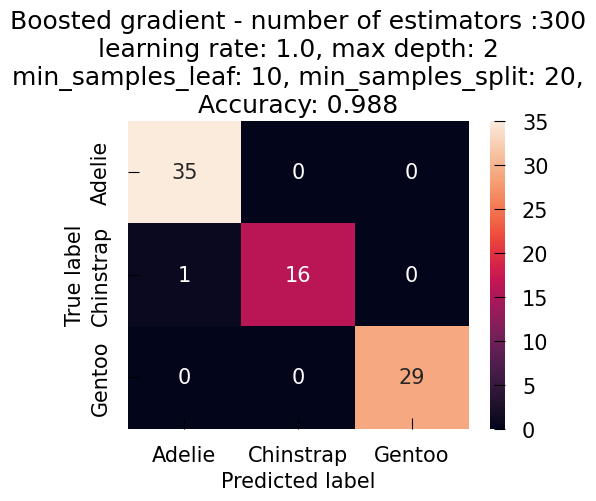

In [123]:
y_pred_test=grid_boosted_roc_auc.predict(X_penguin_test)


bestN = grid_boosted_roc_auc.best_params_["n_estimators"]
bestLR = grid_boosted_roc_auc.best_params_["learning_rate"]
bestMD = grid_boosted_roc_auc.best_params_["max_depth"]
bestMSL = grid_boosted_roc_auc.best_params_["min_samples_leaf"]
bestMSS = grid_boosted_roc_auc.best_params_["min_samples_split"]


plotTitle = """Boosted gradient - number of estimators :{}
learning rate: {}, max depth: {}
min_samples_leaf: {}, min_samples_split: {},
Accuracy: {:.3f}""".format(bestN,bestLR,bestMD,bestMSL,bestMSS,
                           accuracy_score(y_penguin_test,y_pred_test) )


plotConfusionMatrix( y_penguin_test, y_pred_test, 
                    ['Adelie','Chinstrap','Gentoo'] , plotTitle , 
                    ax = None)



In [124]:
BG = GradientBoostingClassifier(learning_rate=grid_boosted_roc_auc.best_params_['learning_rate'],
                              n_estimators=grid_boosted_roc_auc.best_params_['n_estimators'],
                             max_depth=grid_boosted_roc_auc.best_params_['max_depth'],
                             min_samples_leaf=grid_boosted_roc_auc.best_params_['min_samples_leaf'],
                             min_samples_split=grid_boosted_roc_auc.best_params_['min_samples_split'])
BG.fit(X_penguin_train, y_penguin_train)
w=BG.feature_importances_#get the weights


featureW = pd.DataFrame( {'feature': X_penguin.columns,'weight':w} )

# sort them by absolute value
featureWsorted = featureW.sort_values(by=['weight'] , 
                                      ascending=False , 
                                      key=lambda col : col.abs())

# get the non-null ones
print('Features sorted per importance:')
featureWsorted.loc[ featureWsorted["weight"] !=0 ]

Features sorted per importance:


,feature,weight
2,Flipper Length (mm),3.664059e-01
0,Culmen Length (mm),3.554819e-01
5,Delta 13 C (o/oo),2.315813e-01
1,Culmen Depth (mm),2.875650e-02
3,Body Mass (g),1.705484e-02
6,Island_Dream,7.006135e-04
7,Island_Torgersen,1.146903e-05
4,Delta 15 N (o/oo),7.248521e-06
9,Sex_MALE,2.983428e-07


[Back to the ToC](#toc)

# Exercice : <a class="anchor" id="exo"></a>


[Acharjee et al.2016](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1043-4) propose several -omic dataset which they used to predict and gain knowledge on various phenotypic traits in potatos.

Here, we will concentrate on the their transcriptomics dataset and the phenotypic trait of the potato coloration

The data comes in an excel spreadsheet with multiple sheet.

Let's start with the metadata which contains our target variable :

In [125]:
df = pd.read_excel('../data/12859_2016_1043_MOESM1_ESM.xlsx' )
df.index = df.Genotype
df.head()

## color is encoded between 0 and 50. 
# A threshold of 20 is good here to categorize between more white and more yellow potatoes
y = df["Flesh Colour"]>=20
y=y.replace({False:'White',True:'Yellow'})
y.value_counts()


Yellow    49
White     37
Name: Flesh Colour, dtype: int64

Now let's read the sheet containing the transcriptomic data. Thankfully it has already been normalized so we only have minor adjustments to perform.

In [126]:
xls = pd.ExcelFile('../data/12859_2016_1043_MOESM1_ESM.xlsx')
dfT = pd.read_excel(xls, 'Transcriptomics data ')

# transpose and keep only samples for which we have a target value
dfTT = dfT.T.loc[y.index , :]
dfTT.columns = dfT.loc[: , 'FeatureNum'].astype(str) 
dfTT.head()

FeatureNum,12,15,17,21,22,23,29,33,56,57,...,45166,45176,45182,45183,45187,45196,45203,45206,45208,45209
Genotype,,,,,,,,,,,,,,,,,,,,,
CE017,9.684237,7.620347,8.884715,6.561108,10.954142,7.942950,11.061238,12.516361,7.979206,6.255893,...,9.371388,9.351016,6.832953,6.531073,11.059569,9.158997,11.301824,6.534775,8.785558,11.938703
CE069,8.830570,8.296280,9.172465,5.928511,10.991732,8.670691,11.806689,12.606153,8.077820,6.672355,...,9.818819,9.138284,6.872256,6.219264,10.832024,8.952727,10.925734,5.659484,9.006652,11.778435
CE072,9.336937,7.786448,9.217694,6.264187,10.703214,8.257294,12.081581,11.620535,8.206966,6.049687,...,10.325439,9.014987,6.792484,7.103340,11.206071,8.785558,10.952507,5.608868,8.710704,12.149159
CE084,8.568445,7.682821,9.029574,6.273357,10.231839,8.652792,11.448696,12.043662,8.043799,6.613981,...,10.646100,9.182161,6.739931,6.401386,10.768311,8.602304,10.999588,6.643213,9.211117,11.956719
CE110,9.148615,7.417268,5.962352,6.668078,10.170824,7.661002,11.062998,12.262134,8.253087,6.492964,...,9.586301,9.175210,6.818788,6.192561,11.385558,8.459614,10.984700,6.676830,8.789405,11.792416


Unfortunately, the gene column names are not very informative. According to the author, you can go to the supp. Mat. of another paper to get a (partial) annotation.

Your goal is to try to **predict potato color from the transcriptomic data** and, more importantly, to **retrieve which genes are the most important in this prediction**. Focus on the tree-based methods.

Here, the goal is not so much to get a classifier, but to use the process to gain knowledge on the molecular mechanisms which underly potato color. 

#### IMPORTANT CONSIDERATIONS

This dataset is, like many -omic dataset, fairly large (~15k genes have been quantified).
If you do not want to wait forever for your grid search to finish, we recommend you follow these suggestions :

 * start your pipeline with some feature selection, such as `SelectKBest` (in our test, 20 features was enough to get a good predictor)
 * max depth can be fixed at 2, min samples split at 2 and min samples leaf at 1
 * The total number of parameter combinations will control the time it takes:
     * 20 parameter combinations for random forest -> ~20s.
     * 25 parameter combinations for boosted gradient -> ~10s.
     * 25 parameter combinations for ADA boost -> ~20s.

For example, for a random forest:
```python
grid_values = {'classifier__criterion': ['entropy','gini'],
               'classifier__n_estimators':np.arange(1,1000,100), 
               'classifier__max_depth':[2,5],
               'classifier__min_samples_split':[2],
              'classifier__min_samples_leaf':[1]}
```
Represent : $2*10*2*1*1 = 40$ parameter combinations.

> with all these recommendations, the grid search computation on my personnal computer took about a minute



Correction : splitting the data

In [139]:
# %load -r -13 solutions/solution_03_potato.py

Correction : pipeline and parameter space definition

In [140]:
# %load -r 14-40 solutions/solution_03_potato.py

Correction : gridsearch on the pipeline

In [141]:
# %load -r 41-51 solutions/solution_03_potato.py

Correction : reporting the best model fit

In [142]:
# %load -r 52-76 solutions/solution_03_potato.py

Correction : getting the features with the most importance; ie. which genes are the best predictors for potato color ?

In [143]:
# %load -r 77- solutions/solution_03_potato.py